In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
data_dict = pd.read_csv("data_dictionary.csv")
observation = pd.read_csv("C:\\Users\\ASUS\\Desktop\\covid_pure\\training\\observation.csv")
gs = pd.read_csv("C:\\Users\\ASUS\\Desktop\\covid_pure\\training\\goldstandard.csv")
observation.shape

(26674, 18)

In [28]:
drop_columns = [c for c in observation.columns if observation[c].isnull().sum() >=  observation.shape[0]]
observation = observation.drop(columns=drop_columns)
print("Dropped ", drop_columns)


Dropped  ['qualifier_concept_id', 'provider_id', 'visit_occurrence_id', 'visit_detail_id', 'observation_source_value', 'qualifier_source_value']


In [29]:
observations = observation['observation_concept_id'].value_counts().index
print(observations)
d = {}
for obs in observations:
    value = data_dict[data_dict['concept_id'] == obs].concept_name.values[0]
    d[obs] = value

#observation['observation_concept_id'] = observation['observation_concept_id'].map(d)
print(d)

Int64Index([37208405, 4005823, 4196147, 3003798, 1009229], dtype='int64')
{37208405: 'History of alcohol use', 4005823: 'Tobacco user', 4196147: 'Peripheral oxygen saturation', 3003798: 'Blood pressure method', 1009229: 'Cardiac rhythm'}


In [30]:
observation['observation_concept_id'] = observation['observation_concept_id'].map(d)

In [ ]:
observation[observation['person_id'] == 1]

Kenarları 

In [32]:
new_d = observation.groupby(["person_id", "observation_concept_id"]).agg({'value_as_number': "mean",
                                                                  'value_as_string': lambda x: x=="Yes"}).reset_index()
def new_col(row):
    return np.sum(row)

new_d['new_col'] = new_d['value_as_string'].apply(new_col)
new_d.head()

,person_id,observation_concept_id,value_as_number,value_as_string,new_col
0,0,Blood pressure method,NaN,False,0
1,0,History of alcohol use,NaN,"[True, False, False, True, False, True, False,...",6
2,0,Peripheral oxygen saturation,98.5,"[False, False]",0
3,0,Tobacco user,NaN,"[True, False, False, False, False]",1
4,1,Blood pressure method,NaN,False,0


In [44]:
new_data = pd.DataFrame(columns=["person_id", "Blood", "Alcohol", "Oxygen", "Tobacco", "Cardiac"])
person_ids = new_d.person_id.unique()
print(person_ids)
for idx in person_ids:
    d = {
        "person_id": idx,
        "Blood": np.nan,
        "Alcohol":np.nan,
        "Oxygen":np.nan,
        "Tobacco":np.nan,
        "Cardiac":np.nan
    }
    
    sub_data = new_d[new_d['person_id'] == idx].reset_index(drop=True)
    
    for i, obs in enumerate(sub_data['observation_concept_id'].values):
        
        if obs=="Blood pressure method":
            d["Blood"] = sub_data.loc[i, "value_as_number"]
        elif obs == "History of alcohol use":
            d["Alcohol"] = sub_data.loc[i, "new_col"]
        elif obs == "Peripheral oxygen saturation":
            d["Oxygen"] = sub_data.loc[i, "value_as_number"]
        elif obs == "Tobacco user":
            d["Tobacco"] = sub_data.loc[i, "new_col"]
        else:
            d["Cardiac"] = sub_data.loc[i, "value_as_number"]
        
    new_data = new_data.append(d, ignore_index=True)

[   0    1    2 ... 1248 1249 1250]


In [45]:
new_data = new_data.merge(gs, on="person_id")

<AxesSubplot:xlabel='status', ylabel='Oxygen'>

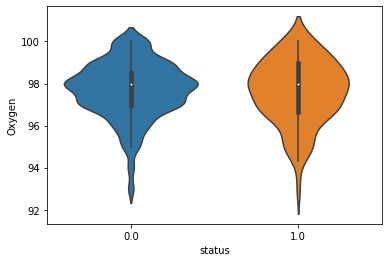

In [56]:
import seaborn as sns
sns.violinplot(data=new_data, x="status", y="Oxygen")

<AxesSubplot:xlabel='status', ylabel='Alcohol'>

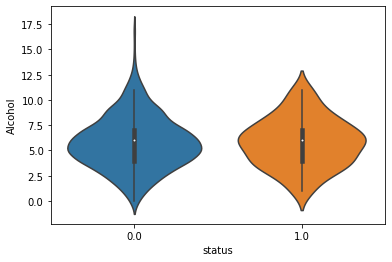

In [57]:
sns.violinplot(data=new_data, x="status", y="Alcohol")

In [49]:
new_data[new_data["Alcohol"] == 17]

,person_id,Blood,Alcohol,Oxygen,Tobacco,Cardiac,status
92,92.0,NaN,17.0,97.666667,4.0,NaN,0.0
970,972.0,NaN,17.0,98.000000,1.0,NaN,0.0


In [51]:
new_data.corr()

,person_id,Blood,Alcohol,Oxygen,Tobacco,Cardiac,status
person_id,1.000000,NaN,-0.035043,-0.013202,-0.041743,NaN,0.013758
Blood,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alcohol,-0.035043,NaN,1.000000,-0.008577,0.014332,NaN,0.002925
Oxygen,-0.013202,NaN,-0.008577,1.000000,0.054908,NaN,-0.012620
Tobacco,-0.041743,NaN,0.014332,0.054908,1.000000,NaN,-0.065955
Cardiac,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status,0.013758,NaN,0.002925,-0.012620,-0.065955,NaN,1.000000


In [35]:
new_data.Tobacco.value_counts()

1    465
2    267
0    253
3     82
4     37
5      8
6      1
Name: Tobacco, dtype: int64

(array([ 12.,  13.,  33.,  33.,  70., 207., 158., 296., 164., 109.]),
 array([ 93. ,  93.7,  94.4,  95.1,  95.8,  96.5,  97.2,  97.9,  98.6,
         99.3, 100. ]),
 <BarContainer object of 10 artists>)

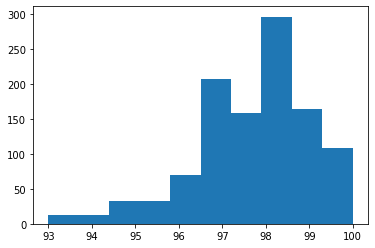

In [36]:
plt.hist(new_data['Oxygen'])